In [1]:
import tensorflow as tf
import numpy as np

import time
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import cPickle as pickle

from IPython import display

from iaf_dynamics import DVBFNoKL
from world import PendulumFullObs

def sample_batch(X, U, batch_size):
    sample = np.random.rand(batch_size) * X.shape[1]
    sample = sample.astype(int)

    batch_x = X[:, sample]
    batch_u = U[:, sample]
    
    return batch_x, batch_u

In [2]:
# Get the dataset
# world = PendulumFullObs()
# X, U, R, S = world.get_data_set(episodes=1000, steps=50)
# pickle.dump([X, U, R, S], open("data/training_set.p", "wb"))
X, U, R, S = pickle.load(open("data/training_set.p", "rb"))

In [3]:
# Define the model
n_obs = 3
n_control = 1
n_latent =  4
n_enc = 10
chkpoint_file = None
m = DVBFNoKL(n_obs, n_control, n_latent, n_enc, chkpoint_file=None)

# Training parameters
training_epochs = 1000
batch_size = 128
steps_per_epoch = X.shape[1] / batch_size
display_step = 10
chkpt_step = 1000
annealing_epochs = 500
annealing_rate = 1.0 / annealing_epochs
learning_rate = 0.001
min_learning_rate = 0.0002
decay_rate = 0.99

In [1]:
import utils
timestamp=utils.get_timestamp()

epochs = []
total_loss = []
rec_loss = []

import os
_RESULT_PATH = 'results/'
if not os.path.exists(_RESULT_PATH):
    os.makedirs(_RESULT_PATH)
    
result_details_path = _RESULT_PATH + '%s' % timestamp + '_result_details.txt'    
result_details_file = open(result_details_path, 'w')
result_details_file.write('chkpoint_file = ' + str(chkpoint_file) + '\n')
result_details_file.write('training_epochs = ' + str(training_epochs) + '\n')
result_details_file.write('annealing_epochs = ' + str(annealing_epochs) + '\n')
result_details_file.write('initial annealing_rate = ' + str(annealing_rate) + '\n')
result_details_file.write('initial learning_rate = ' + str(learning_rate) + '\n')
result_details_file.write('decay_rate = ' + str(decay_rate) + '\n')
result_details_file.close()

# Training cycle
for epoch in range(training_epochs):
    
    # Decay the learning rate
    if learning_rate > min_learning_rate:
        learning_rate *= decay_rate
        
    if annealing_rate < 1.0:
        annealing_rate += 1.0 / annealing_epochs

    # Train one epoch 
    avg_total_loss = .0
    avg_rec_loss = .0
    for i in range(steps_per_epoch):
        batch_x, batch_u = sample_batch(X, U, batch_size)
        temp_total_loss, temp_rec_loss = m.train(batch_x, batch_u, learning_rate, annealing_rate)
        avg_total_loss += temp_total_loss
        avg_rec_loss += temp_rec_loss
    
    avg_total_loss /= steps_per_epoch
    avg_rec_loss /= steps_per_epoch
    
    total_loss.append(avg_total_loss)
    rec_loss.append(avg_rec_loss)
    epochs.append(epoch)

    # Plot the results
    if epoch % display_step == 0:
                
        plt.close()
        f, axarr = plt.subplots(1, 2, figsize=(13, 4))
        axarr[0].plot(epochs, total_loss)
        axarr[0].set_xlabel('Epochs')
        axarr[0].set_title('Total Loss')
        axarr[0].annotate("Learning Rate: " + str(learning_rate), xy=(0.05, 0.05), xycoords='axes fraction')
        axarr[0].set_ylim(-9.0, 10)
        axarr[1].plot(epochs, rec_loss)
        axarr[1].set_xlabel('Epochs')
        axarr[1].set_title('Rec Loss')
        axarr[1].set_ylim(-9.0, 10)

        if epoch % chkpt_step == 0 or epoch == training_epochs-1:
            plt.savefig(_RESULT_PATH + '%s' % timestamp + '_Each_Loss_Epoch_' + str(epoch) + '.png')

        display.display(plt.gcf())
        display.clear_output(wait=True)

    if epoch % chkpt_step == 0 or epoch == training_epochs-1:
        
        #save_checkpoint
        utils.save_checkpoint(sess=m.sess, timestamp=timestamp, checkpoint=epoch)
        
        plt.close()
        f, axarr = plt.subplots(1, 1, figsize=(13, 4))
        axarr.plot(epochs, total_loss)
        axarr.set_xlabel('Epochs')
        axarr.set_title('Total Loss')
        axarr.annotate("Learning Rate: " + str(learning_rate), xy=(0.05, 0.05), xycoords='axes fraction')
        axarr.annotate("Annealing Rate: " + str(annealing_rate), xy=(0.05, 0.1), xycoords='axes fraction')
        axarr.annotate("Final Loss: " + str(total_loss[-1]), xy=(0.05, 0.0), xycoords='axes fraction')
        axarr.set_ylim(-14.0, 10)
        
        plt.savefig(_RESULT_PATH + '%s' % timestamp + '_Loss_Epoch_' + str(epoch) + '.png')

2017_10_09_18_20


NameError: name 'chkpoint_file' is not defined

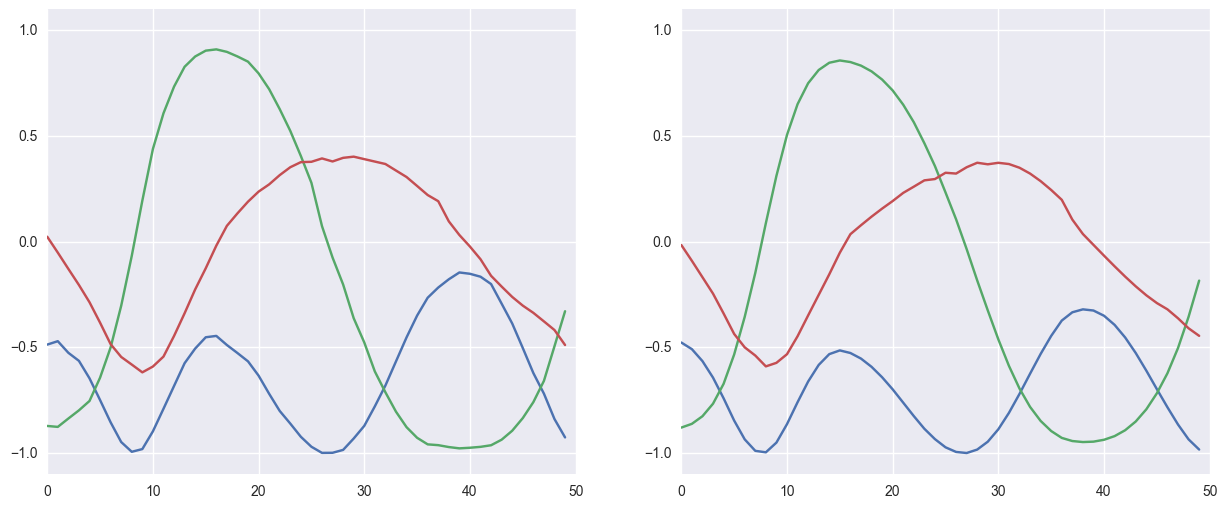

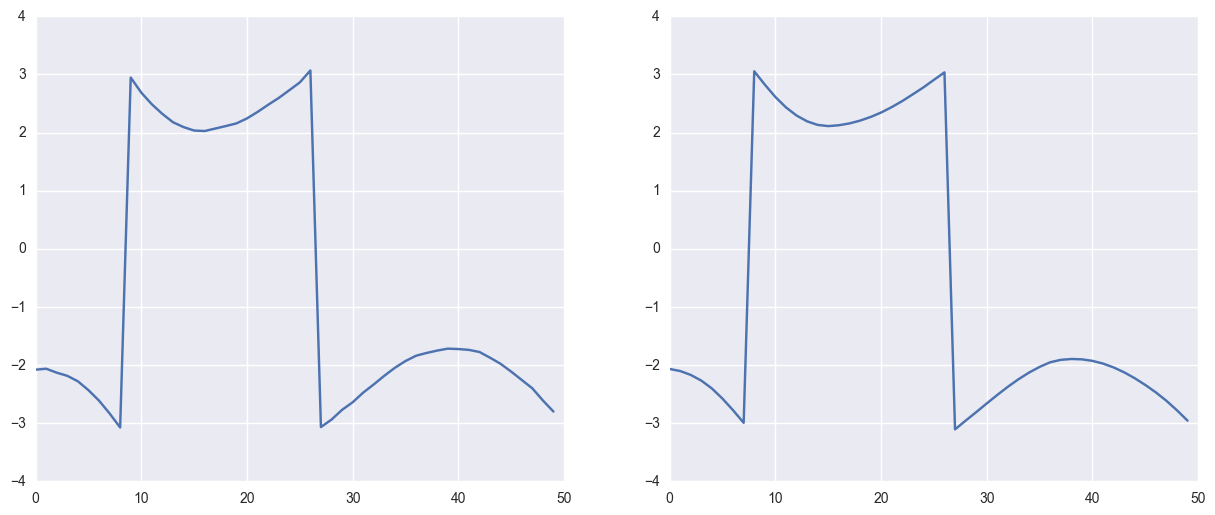

In [11]:
# Get the true trajectory
# X_temp, U_temp, R_temp, S_temp = world.get_data_set(episodes=128, steps=50)
# pickle.dump([X_temp, U_temp, R_temp, S_temp], open("data/test_set.p", "wb"))
X_temp, U_temp, R_temp, S_temp = pickle.load(open("data/test_set.p", "rb"))
x_obs = m.sess.run((m.gen_x_mean), feed_dict={m.x: X_temp, m.u:U_temp})

# Plot the position and reward of low dim pendulum
e = int(np.random.rand() * 100)
plt.close()
f, axarr = plt.subplots(1, 2, figsize=(15, 6))
axarr[0].plot(x_obs[:, e, 0])
axarr[0].plot(x_obs[:, e, 1])
axarr[0].plot(x_obs[:, e, 2])
axarr[0].set_ylim(-1.1, 1.1)
axarr[1].plot(X_temp[:, e, 0])
axarr[1].plot(X_temp[:, e, 1])
axarr[1].plot(X_temp[:, e, 2])
axarr[1].set_ylim(-1.1, 1.1)
plt.savefig(_RESULT_PATH + '%s' % timestamp + '_PositionPlot.png')
plt.show()

plt.close()
f, axarr = plt.subplots(1, 2, figsize=(15, 6))
axarr[0].plot(np.arctan2(x_obs[:, e, 1], x_obs[:, e, 0]))
axarr[1].plot(np.arctan2(X_temp[:, e, 1], X_temp[:, e, 0]))
plt.savefig(_RESULT_PATH + '%s' % timestamp + '_ArcTanPlot.png')
plt.show()